In [24]:
import numpy as np
import matplotlib.pyplot as plt
import pandas as pd

from scipy.stats import pearsonr

from sklearn.impute import SimpleImputer

from scipy.stats import chi2_contingency
from scipy.stats import chi2

df = pd.read_pickle('treino.pkl.gz')

# ESTE NOTEBOOK TRATA DAS VARIÉVEIS: 'valor_emprestimo', 'custo_ativo', 'emprestimo_custo'
# suponho que sejam redundantes

In [25]:
plt.style.use('dark_background')
plt.rcParams['figure.figsize'] = (20, 8)

In [26]:
# preguiça de pensar nas possíveis combinações entre as variáveis

l1 = ['valor_emprestimo', 'custo_ativo', 'emprestimo_custo']
l2 = []
l3 = []
for i in l1:
    for n in l1:
        if i != n:
            l2.append([i, n])
for i in l2:
    i.sort()
for i in l2:
    if i not in l3:
        l3.append(i)

custo_ativo , valor_emprestimo : nan


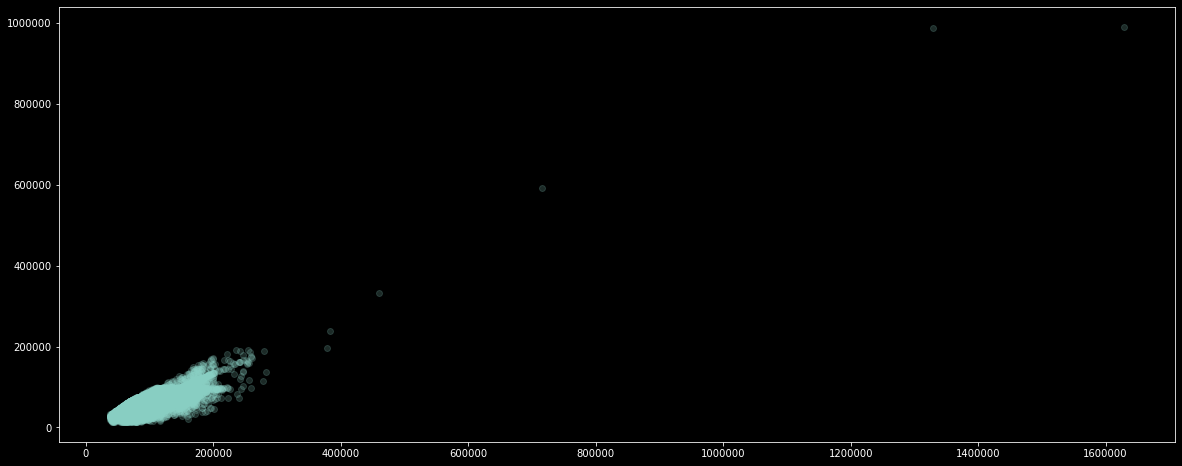

emprestimo_custo , valor_emprestimo : 0.37


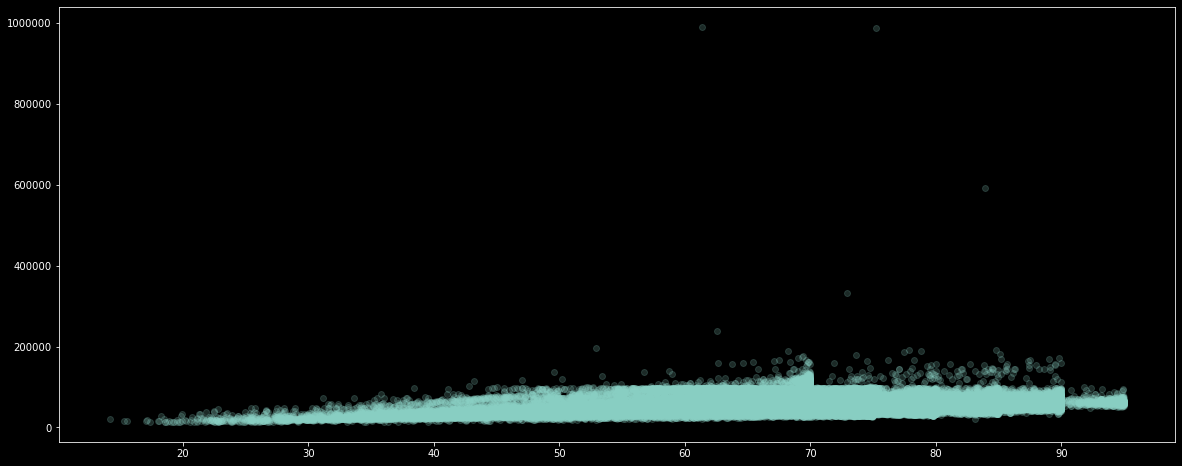

custo_ativo , emprestimo_custo : -0.3


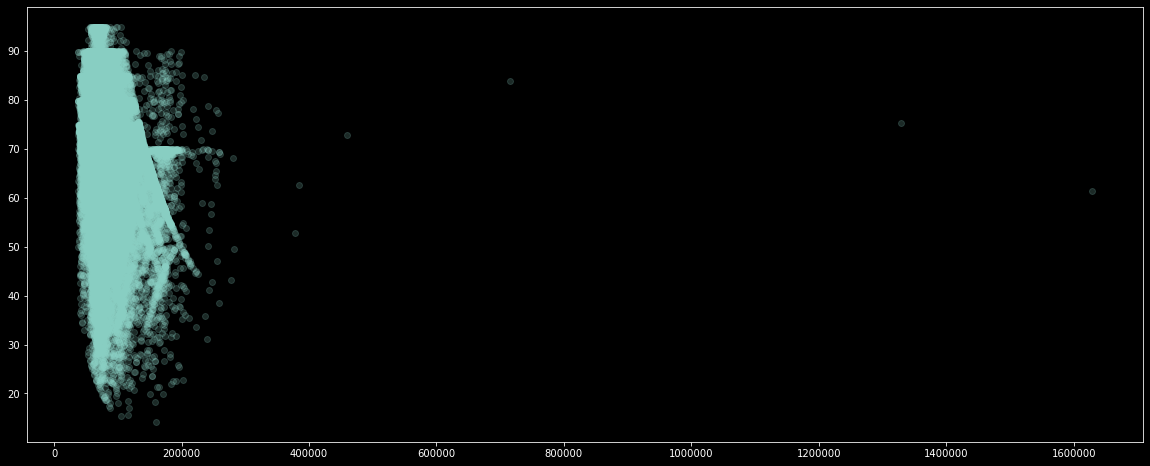

In [27]:
for i in l3:
    print(i[0], ',', i[1], ':', round(pearsonr(df[i[0]], df[i[1]])[0], 2))
    plt.scatter(df[i[0]], df[i[1]], alpha = 0.2)
    plt.show()

In [28]:
# existe correlação linear entre 'custo_ativo' e 'valor_emprestimo'
# subtraindo um do outro, obtemos algo parecido com o valor de 'emprestimo_custo', no sentido de que se refere
# tanto ao custo do ativo, quanto valor do empréstimo (acredito que esta nova feature possuirá correlação
# com 'emprestimo_custo')

df['dif_ativo_emp'] = df['custo_ativo'] - df['valor_emprestimo']

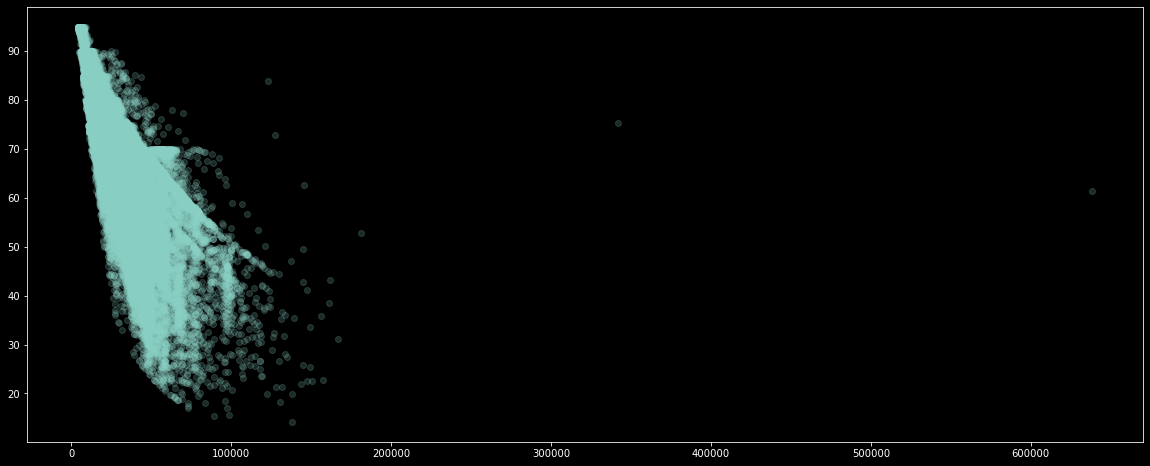

In [29]:
pearsonr(df['dif_ativo_emp'], df['emprestimo_custo'])
plt.scatter(df['dif_ativo_emp'], df['emprestimo_custo'], alpha = 0.2)
plt.show()

In [30]:
# como unificar 'dif_ativo_emp' e 'emprestimo_custo' ? 
# posso eliminar 'emprestimo_custo' e manter 'dif_ativo_emp' ?

# em seguida, testo a capacidade de 'dif_ativo_emp' de discriminar 'default'
# para tanto, categorizarei a variável 'dif_ativo_emp'

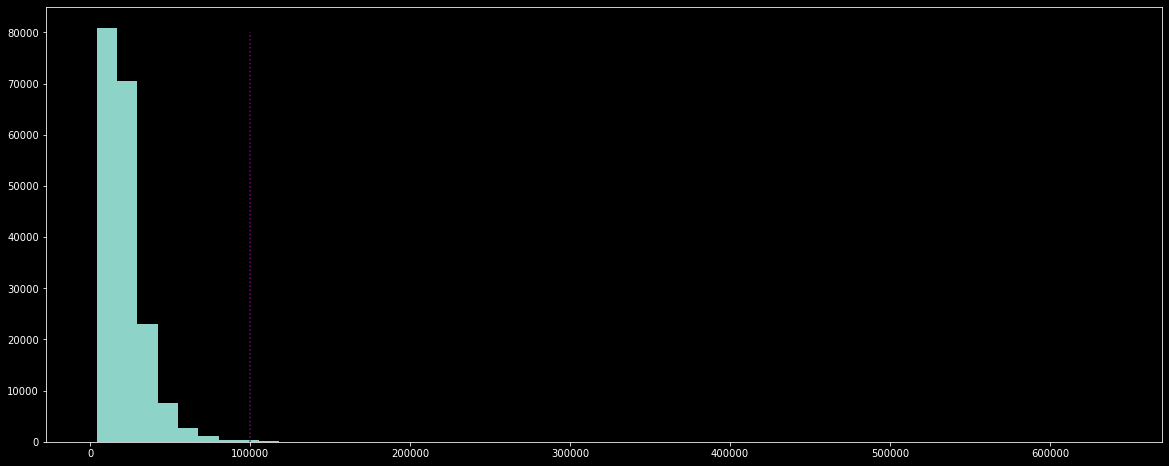

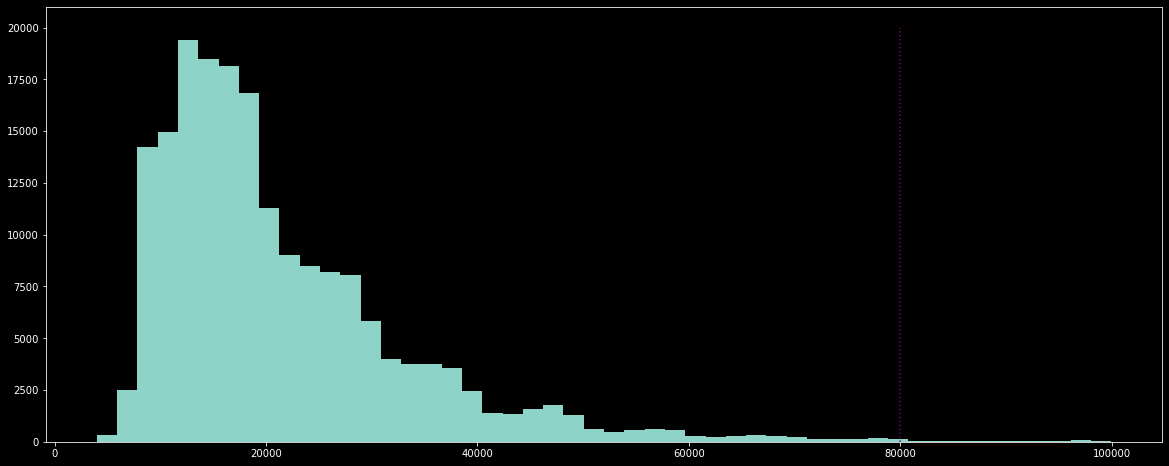

proporção de dados ainda nesta distribuição: 0.9989759975981515 
a linha indica à partir de que ponto desta, a próxima será plotada


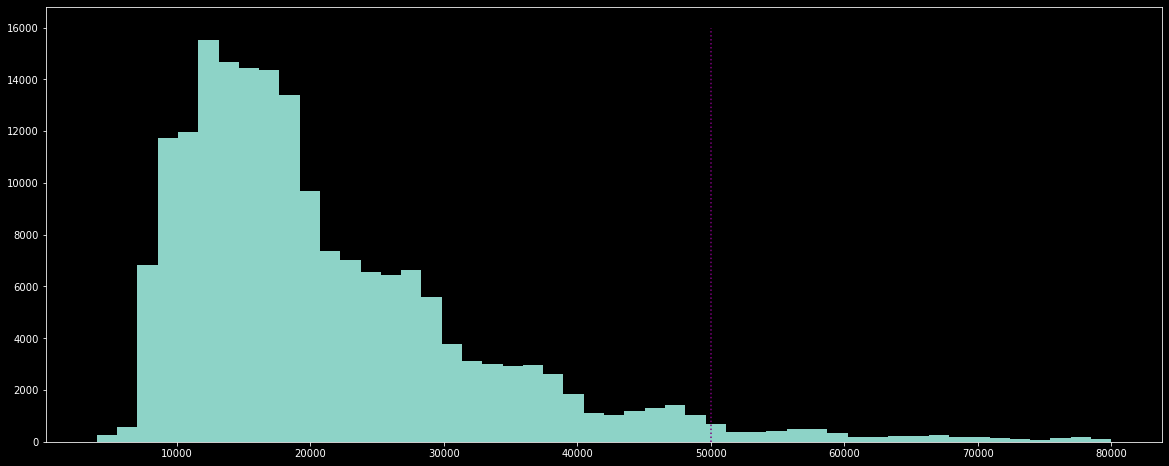

proporção de dados ainda nesta distribuição: 0.9961934989250656 
a linha indica à partir de que ponto desta, a próxima será plotada


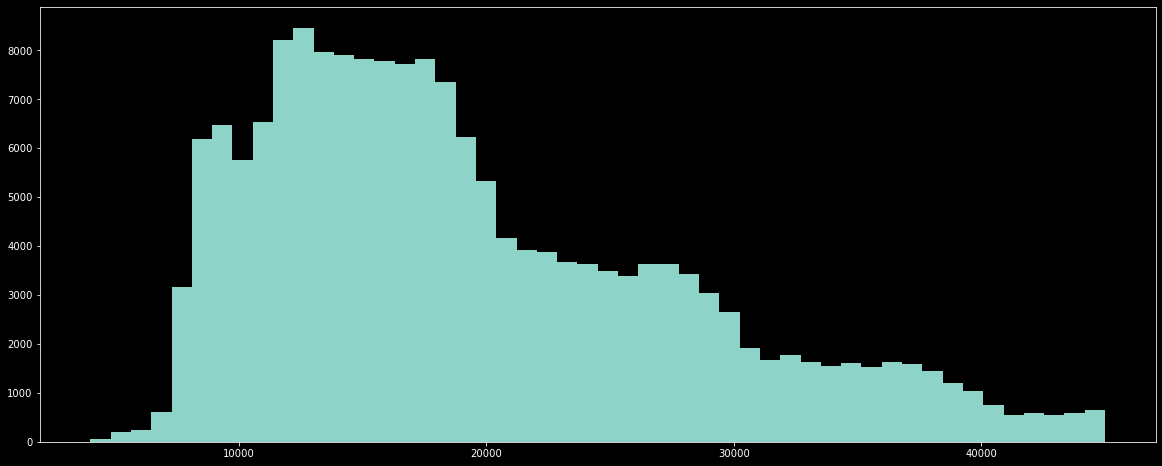

proporção de dados ainda nesta distribuição: 0.9467143462200373


In [31]:
# eliminação visual de outliers ('dif_ativo_emp')

# 1
plt.hist(df['dif_ativo_emp'], bins = 50)
plt.plot([100000, 100000], [0, 80000], ls = ':', color = 'purple')
plt.show()
# 2
plt.hist(df.loc[df['dif_ativo_emp'] <= 100000, 'dif_ativo_emp'], bins = 50)
plt.plot([80000, 80000], [0, 20000], ls = ':', color = 'purple')
plt.show()
print('proporção de dados ainda nesta distribuição:', 
      len(df.loc[df['dif_ativo_emp'] <= 100000, 'dif_ativo_emp']) / len(df), 
     '\na linha indica à partir de que ponto desta, a próxima será plotada')
# 3
plt.hist(df.loc[df['dif_ativo_emp'] <= 80000, 'dif_ativo_emp'], bins = 50)
plt.plot([50000, 50000], [0, 16000], ls = ':', color = 'purple')
plt.show()
print('proporção de dados ainda nesta distribuição:', 
      len(df.loc[df['dif_ativo_emp'] <= 80000, 'dif_ativo_emp']) / len(df), 
     '\na linha indica à partir de que ponto desta, a próxima será plotada')
# 4
plt.hist(df.loc[df['dif_ativo_emp'] <= 45000, 'dif_ativo_emp'], bins = 50)
# plt.plot([50000, 50000], [0, 16000], ls = ':', color = 'purple')
plt.show()
print('proporção de dados ainda nesta distribuição:', 
      len(df.loc[df['dif_ativo_emp'] <= 45000, 'dif_ativo_emp']) / len(df))

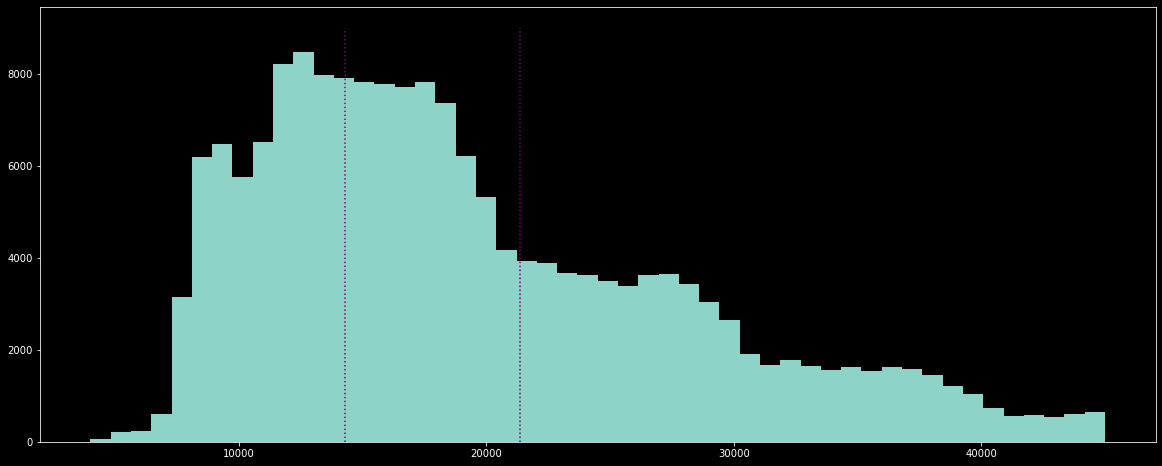

In [32]:
# estabeleço que outliers são valores acima de 45000(este threshold elimina 5,4% dos dados)

# em seguida, dividir os dados restantes em três grupos de acordo com percentis (3)
df_dif_no_otlr = df.loc[df['dif_ativo_emp'] <= 45000]

thrshld1 = np.quantile(a = df_dif_no_otlr['dif_ativo_emp'], q = 0.33)
thrshld2 = np.quantile(a = df_dif_no_otlr['dif_ativo_emp'], q = 0.66)

plt.hist(df_dif_no_otlr['dif_ativo_emp'], bins = 50)
plt.plot([thrshld1, thrshld1], [0, 9000], ls = ':', color = 'purple')
plt.plot([thrshld2, thrshld2], [0, 9000], ls = ':', color = 'purple')
plt.plot()
plt.show()

In [33]:
def categorize_dif(x, thrshld1, thrshld2):
    if x <= thrshld1:
        return 'low'
    if x > thrshld1 and x <= thrshld2:
        return 'medium'
    if x > thrshld2:
        return 'high'
    
df_dif_no_otlr['dif_ativo_emp'] = df_dif_no_otlr['dif_ativo_emp'].apply(lambda x: categorize_dif(x, thrshld1, thrshld2))

c:\users\fkhon\appdata\local\programs\python\python37\lib\site-packages\ipykernel_launcher.py:9: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: http://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  if __name__ == '__main__':


In [34]:
pd.crosstab(df_dif_no_otlr['dif_ativo_emp'], df_dif_no_otlr['default'])

default,0,1
dif_ativo_emp,,
high,49035,11001
low,43177,15096
medium,45781,12494


In [35]:
chi_stat, p, dof, ex = chi2_contingency(pd.crosstab(df_dif_no_otlr['dif_ativo_emp'], df_dif_no_otlr['default']))

In [36]:
ex

array([[46915.61946722, 13120.38053278],
       [45537.90880827, 12735.09119173],
       [45539.47172451, 12735.52827549]])

In [37]:
crit = chi2.ppf(q = (1 - 0.05), df = dof)

In [38]:
chi_stat

1004.034753968129

In [39]:
crit

5.991464547107979

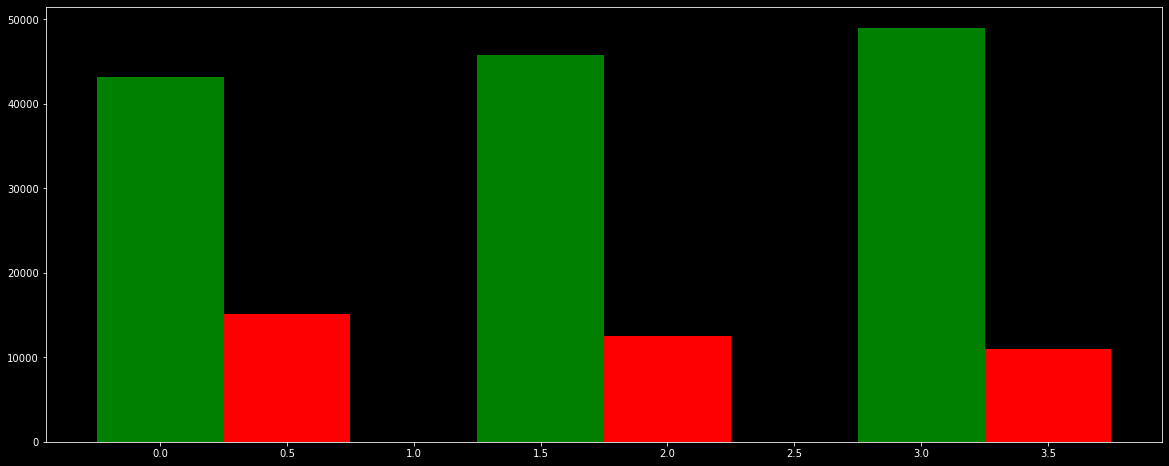

In [40]:
low_dif = df_dif_no_otlr.loc[df_dif_no_otlr['dif_ativo_emp'] == 'low']
medium_dif = df_dif_no_otlr.loc[df_dif_no_otlr['dif_ativo_emp'] == 'medium']
high_dif = df_dif_no_otlr.loc[df_dif_no_otlr['dif_ativo_emp'] == 'high']

plt.bar([0], low_dif['default'].value_counts().iloc[0], width = 0.5, color = 'green')
plt.bar([0.5], low_dif['default'].value_counts().iloc[1], width = 0.5, color = 'red')

plt.bar([1.5], medium_dif['default'].value_counts().iloc[0], width = 0.5, color = 'green')
plt.bar([2], medium_dif['default'].value_counts().iloc[1], width = 0.5, color = 'red')

plt.bar([3], high_dif['default'].value_counts().iloc[0], width = 0.5, color = 'green')
plt.bar([3.5], high_dif['default'].value_counts().iloc[1], width = 0.5, color = 'red')

plt.show()

In [43]:
print(len(high_dif) - len(low_dif))
((len(high_dif) - len(low_dif)) / len(medium_dif)) * 100
# cada percentil possui aproximadamente o mesmo número de elementos
# a maior diferença existe entre 'low_dif' e 'high_dif'()

# a diferença entre tamanhos das bases de dados é,na pior das hipóteses:

1763


3.0253110253110256

In [18]:
# porcentagem de 'default' em cada grupo, dividido de acordo com diferença entre custo do ativo e valor do 
# empréstimo(categorizada)

print(round(low_dif['default'].value_counts(1).iloc[1], 2))
print(round(medium_dif['default'].value_counts(1).iloc[1], 2))
print(round(high_dif['default'].value_counts(1).iloc[1], 2))

# quanto mais alto o valor da diferença, menor a ocorrência de 'default'

0.26
0.21
0.18
